Import Libraries

In [9]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
import os
from transformers import DistilBertModel, DistilBertTokenizer
from torch.optim import AdamW, SGD
from torch.utils.data import DataLoader
import re
import numpy as np
from image_and_text_dataset import ImageTextGarbageDataset

Define data directories. Modify the path to your local directory.

In [10]:
data_dir = "/Users/rzhang/Desktop/talc_assignment_2"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

Define transformations for the data.

In [11]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

Define the Classifier:
1. Image feature extractor: ResNet50
2. Text feature extractor: DistilBERT
3. Fusion and classification layers
4. Forward pass

In [12]:
class ResNetMultimodalClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        
        # Image feature extractor (ResNet50)
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.image_features = nn.Sequential(*list(resnet.children())[:-1])
        
        # Text feature extractor (DistilBERT)
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_drop = nn.Dropout(0.3)
        
        # Freeze DistilBERT parameters
        for param in self.distilbert.parameters():
            param.requires_grad = False
            
        # Fusion and classification layers
        self.image_fc = nn.Linear(2048, 512)  # ResNet50 features
        self.text_fc = nn.Linear(768, 512)    # DistilBERT features
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),  # 512 + 512 = 1024
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # Process images
        img_features = self.image_features(images)
        img_features = img_features.squeeze(-1).squeeze(-1)
        img_features = self.image_fc(img_features)

        # Process text
        text_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = self.text_drop(text_output[:,0])
        text_features = self.text_fc(text_features)

        # Combine features
        combined_features = torch.cat((img_features, text_features), dim=1)
        output = self.classifier(combined_features)
        return output


Define the Training Function:
1. Best accuracy
2. For each epoch
3. For each phase
4. Forward pass
5. Backward pass
6. Update parameters

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=None):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch in dataloaders[phase]:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(images, input_ids, attention_mask)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), "final_resnet_adamW_model.pth")

    print(f"Best val Acc: {best_acc:.4f}")
    return model

Start Training:
1. Set device
2. Create datasets
3. Create dataloaders
4. Create model
5. Define loss function
6. Define optimizer

In [6]:
# Set device
device = (
        torch.device("cuda") if torch.cuda.is_available()
        else torch.device("mps") if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
print(f"Using device: {device}")
    
# Create datasets
max_len = 24
data_splits = {
        "train": ImageTextGarbageDataset(train_dir, transform=transform["train"], max_len=max_len),
        "val": ImageTextGarbageDataset(val_dir, transform=transform["val"], max_len=max_len),
        "test": ImageTextGarbageDataset(test_dir, transform=transform["test"], max_len=max_len),
    }

# Create dataloaders
dataloaders = {
    "train": DataLoader(data_splits["train"], batch_size=32, shuffle=True, num_workers=2),
    "val": DataLoader(data_splits["val"], batch_size=32, shuffle=False, num_workers=2),
    "test": DataLoader(data_splits["test"], batch_size=32, shuffle=False, num_workers=2)
}
    
# Create model
model = ResNetMultimodalClassifier(num_classes=4).to(device)
    
# Define loss function
criterion = nn.CrossEntropyLoss()
    
    
#AdamW (Adam with weight decay)
optimizer = AdamW(model.parameters(), 
                     lr=2e-5,
                     weight_decay=0.01)  # L2 regularization
    

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=8, device=device) 

Using device: mps
Epoch 1/8
train Loss: 0.9079 Acc: 0.6333
val Loss: 0.6021 Acc: 0.7750
Epoch 2/8
train Loss: 0.4998 Acc: 0.8088
val Loss: 0.5147 Acc: 0.8072
Epoch 3/8
train Loss: 0.3438 Acc: 0.8718
val Loss: 0.5087 Acc: 0.8150
Epoch 4/8
train Loss: 0.2311 Acc: 0.9169
val Loss: 0.5527 Acc: 0.8056
Epoch 5/8
train Loss: 0.1564 Acc: 0.9473
val Loss: 0.6166 Acc: 0.8083
Epoch 6/8
train Loss: 0.1064 Acc: 0.9664
val Loss: 0.6786 Acc: 0.8050
Epoch 7/8
train Loss: 0.0741 Acc: 0.9782
val Loss: 0.7623 Acc: 0.8094
Epoch 8/8
train Loss: 0.0608 Acc: 0.9825
val Loss: 0.7729 Acc: 0.8161
Best val Acc: 0.8161


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define data directory
data_dir = "/Users/rzhang/Desktop/talc_assignment_2"
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

# Get class names from the test directory and filter out hidden files
class_names = sorted([f for f in os.listdir(test_dir) 
                     if not f.startswith('.') and os.path.isdir(os.path.join(test_dir, f))])
print("Classes:", class_names)




Classes: ['Black', 'Blue', 'Green', 'TTR']


Using device: mps
Accuracy on test set: 78.00%


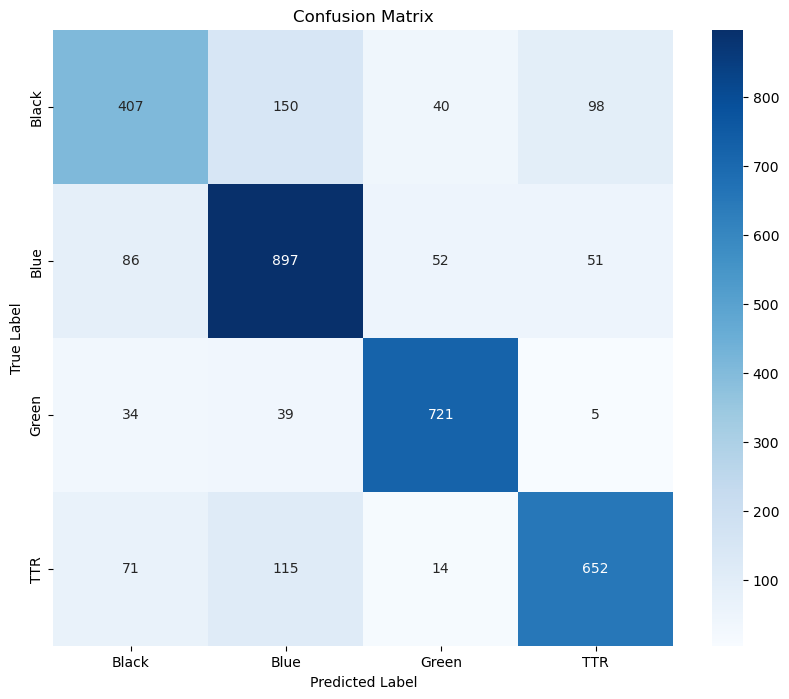

Accuracy for Black: 58.56%
Accuracy for Blue: 82.60%
Accuracy for Green: 90.24%
Accuracy for TTR: 76.53%


In [15]:
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")

# Create and load model
model = ResNetMultimodalClassifier(num_classes=4).to(device)
model.load_state_dict(torch.load("final_resnet_adamW_model.pth", weights_only=True))
model.eval()

# Create test dataset and dataloader
test_dataset = ImageTextGarbageDataset(test_dir, transform=transform["test"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(images, input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Calculate and display per-class accuracy with class names
per_class_accuracy = cm.diagonal() / cm.sum(axis=1) * 100
for i, (name, acc) in enumerate(zip(class_names, per_class_accuracy)):
    print(f'Accuracy for {name}: {acc:.2f}%') 